# Read everything

In [1]:
import glob

In [2]:
# !pip install pyjanitor
import janitor

In [3]:
import pandas as pd
import numpy as np

In [4]:

import logging
import pathlib

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

In [5]:
l = logging.getLogger()

In [6]:
l.setLevel('WARNING')

In [7]:
def load_dir(paths="safeside-out"):
    files = []
    for path in paths:
        files += glob.glob(f'{path}/*/perf-output.csv')
    dfs = []
    for fn in files:
        fn = pathlib.Path(fn)
        category, benchname = fn.parts[-3], fn.parts[-2]
        # print(category,benchname)


        try:
            df = pd.read_csv(fn, comment='#', skip_blank_lines=True,)

        except pd.errors.EmptyDataError:
            l.debug(f'Note: {fn} was empty. Skipping.')
            continue # will skip the rest of the block and move to next file


        # order inferred from documentation of perf stat; look at the CSV format section
        df.columns = [
            'timestamp',
            'value',
            'unknown0',
            'counter',
            'cycles collected',
            'percentage collected',
            'unknown1',
            'unknown2'
        ]




        assert np.all(df.unknown0.isna())
        assert np.all(df.unknown1.isna())
        assert np.all(df.unknown2.isna())

        df['benchname']=benchname
        df['category']=category
        df = df[
            ['category', 'benchname','timestamp','value','counter']
        ]
        dfs.append(df)



    df

    # Cast into wide form



    import janitor


    dfs_wide = [
        janitor.pivot_wider(df, index=['timestamp','category', 'benchname'], names_from="counter", values_from="value",)
        for df in dfs
    ]

    df_big = pd.concat(dfs_wide)

    df_big
    return df_big

## Load data and Run Diaggnostics

In [8]:
df = load_dir(["safeside-out", "pts-out"])

,timestamp,cycles,r010D,r01C5,r0248,r0283,r0480,r0CA3,r3824,r40D1,r8189,r8889,rF824
count,3948.000000,3.924000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03,3.948000e+03
mean,534.488125,6.176191e+10,4.748034e+08,6.465217e+07,1.741910e+09,2.108219e+08,4.970154e+08,1.853932e+11,7.287227e+08,3.495464e+08,3.296888e+07,4.375927e+06,1.277009e+09
std,507.198170,1.868802e+10,6.614401e+08,1.050322e+08,1.095363e+09,6.044204e+08,1.262915e+09,6.797810e+10,3.457612e+08,1.909675e+08,5.623917e+07,7.510396e+06,6.058962e+08
min,5.001466,2.065733e+07,1.842366e+06,9.434200e+04,2.001900e+04,3.405280e+05,1.476306e+06,7.246826e+07,3.755890e+05,1.203070e+05,6.260500e+04,5.790000e+02,2.833440e+05
25%,122.736579,6.494161e+10,1.930274e+08,1.622928e+07,9.517455e+07,1.425825e+07,2.159041e+08,1.899081e+11,5.207298e+08,3.512132e+08,7.364966e+06,4.187150e+04,1.112706e+09
50%,336.017688,6.548659e+10,2.368902e+08,2.643427e+07,2.399443e+09,1.694336e+07,2.354157e+08,2.043077e+11,9.235517e+08,4.050988e+08,1.179377e+07,2.887855e+05,1.620644e+09
75%,836.549840,6.665972e+10,2.816207e+08,3.589444e+07,2.481300e+09,1.172999e+08,2.660565e+08,2.122847e+11,9.439738e+08,4.106687e+08,1.742069e+07,3.238412e+06,1.652091e+09
max,1799.669947,7.875980e+10,2.921198e+09,4.563424e+08,2.865171e+09,3.044035e+09,9.006241e+09,2.995298e+11,1.677358e+09,1.145868e+09,2.371922e+08,3.017604e+07,2.480309e+09


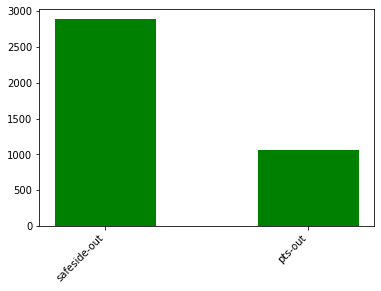

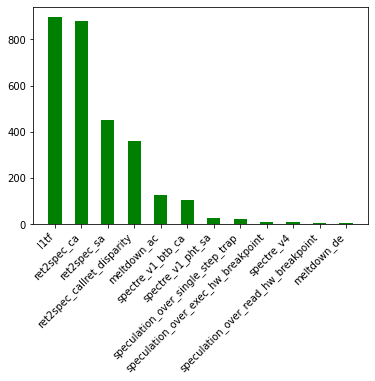

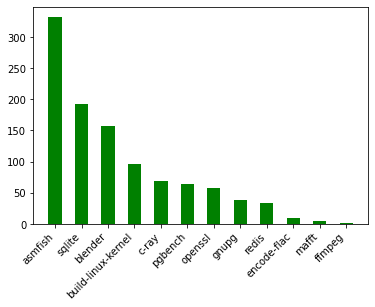

In [9]:
%matplotlib inline
def run_diagnostics(df):
    
    
        # run 
    display(df.describe())
    
    def mybar(column):
        c = Counter(column)
        plt.bar(*zip(*c.most_common()), width=.5, color='g')
        plt.xticks(rotation=45, ha='right')

        plt.show()    
        
    mybar(df['category'])
    for cat in df['category'].unique():
        mybar(
            df[
                df['category'] == cat
            ]['benchname']
        )

run_diagnostics(df)

# Run MLJAR

In [10]:
from supervised.automl import AutoML


/u/xr5ry/miniconda3/envs/pfcml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
to_drop = {"timestamp", "benchname"}

In [12]:
ycol = {"category"}

In [13]:
xcol = set(df.columns) - to_drop - ycol

In [14]:
# xcol = set(xcol) - {"r0248"}


In [15]:
xcol

{'cycles',
 'r010D',
 'r01C5',
 'r0248',
 'r0283',
 'r0480',
 'r0CA3',
 'r3824',
 'r40D1',
 'r8189',
 'r8889',
 'rF824'}

In [16]:
xcol = list(xcol)
ycol = list(ycol)

In [17]:
X = df[xcol]

In [18]:
y = df[ycol]

In [19]:
# from numpy import array
# from numpy import argmax
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# # integer encode
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(y.values.ravel())
# print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
# y = integer_encoded

In [20]:
from sklearn.model_selection import train_test_split


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [22]:
automl = AutoML(mode="Explain")


In [23]:
y.shape

(3948, 1)

In [24]:
X.shape

(3948, 12)

In [25]:
y_train.shape

(2961, 1)

In [26]:
X_train.shape

(2961, 12)

In [27]:
automl = AutoML()
automl.fit(X_train, y_train.values.flatten())
predictions = automl.predict(X_test)

AutoML directory: AutoML_7
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.57772 trained in 0.33 seconds
2_DecisionTree logloss 0.04584 trained in 10.02 seconds
3_Linear logloss 0.014893 trained in 7.74 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.008945 trained in 6.27 seconds
5_Default_NeuralNetwork logloss 0.03729 trained in 4.75 seconds
6_Default_RandomForest logloss 0.002511 trained in 7.97 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.002511 trained in 0.28 seconds
AutoML fit time: 46.18 seconds
AutoML best model: 6_Default_RandomForest


In [28]:
from sklearn.metrics import accuracy_score

In [29]:
y_test.values.flatten().shape

(987,)

In [30]:
predictions.shape

(987,)

In [31]:
import requests

In [32]:
accuracy_score(y_test.values.flatten(),predictions)

1.0

In [33]:
automl.report()

In [34]:
automl.

SyntaxError: invalid syntax (1876159555.py, line 1)